In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor as LOF

# Question 1
#### Using the saved plots and looking at the clean data, do you think there are still outliers in the pCO2 data? Why do you think so?
Yes I believe that the cleaned data still has outliers. Not only are large spikes and drops in data present, but they are only present in the measurement of CO2 and not in any of the other measurements at the same time. This makes it unlikely that the sensor is measuring an anomolous water parcel passed the mouring at that time, as this hypothetical parcels would no doubt have interesting properties measured by at least one of the other sensors due to their interrelatedness. For example, the pC02 suddenly drops from about 750 to 530 uatm and back up to 740 uatm in a span of 1 hour on the 28th of September at 00:33, and does this at 14:30 and again at 00:30 for the next few days. While 530 utam is within the range of reasonable pCO2 values, since it changes so quickly, and since no other sensors have anomolous values at or near this time it is likely an outlier. Furthermore, due to the pattern of this presence of this outlier it is likely somehting wrong with the sensor. <br>

Otherwise there are clear outliers that are not within the reasonable range for measurements in this reagion. For example the pCO2 on september 6th is recorded to be over 2000 uatm while the typical range for pCO2 in seawater is 100-1000 uatm, with values around 1000 uatm only occuring in warm waters (GLOBAL OCEAN SURFACE WATER PARTIAL PRESSURE OF CO2 DATABASE:MEASUREMENTS PERFORMED DURING 1957–2016, NOAA/NCEI/OCADS).

# Question 2
QC Flag (0-9): 0 = no QC; 1 = good; 2 = probably good!;  use with caution; 3 = probably bad; 4 = bad; 6 = bad down-sampling; 7 = Averaged value; 8 = Interpolated Value; 9 = Missing Value (NaN)

In [2]:
data = pd.read_csv('BaynesSoundMooring_5m_CO2PartialPressure_20210923T000000Z_20210925T235959Z_RAW.csv', header=52, usecols=[0,1,2])

# convert to datetime
data['datetime'] = pd.to_datetime(data['#"Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)"'])

# drop the non-converted datetime axis
data.drop(columns='#"Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)"', inplace=True)

#convert other columns to numeric
data['pCO2'] = pd.to_numeric(data[' "CO2 Partial Pressure (pCO2 uatm)"'], errors = 'coerce')
data['flag'] = pd.to_numeric(data[' "CO2 Partial Pressure QC Flag"  '], errors = 'coerce')

# drop the non-converted axis
data.drop(columns=' "CO2 Partial Pressure (pCO2 uatm)"', inplace=True)
data.drop(columns=' "CO2 Partial Pressure QC Flag"  ', inplace=True)

In [3]:
# 12:30 to 14:30 during 24-Sept-2021 - assuming timezone is UTC
daymin = pd.to_datetime('2021-09-24 12:30:00Z')
daymax = pd.to_datetime('2021-09-24 14:30:00Z')

# trim by selected dates
data = data[(data.datetime >= daymin) & (data.datetime <= daymax)]
data = data.reset_index(drop=True)
data

datetime        pCO2  flag
0    2021-09-24 12:30:00.675000+00:00  637.725201     1
1    2021-09-24 12:30:01.741000+00:00  637.607007     1
2    2021-09-24 12:30:03.572000+00:00  637.065285     1
3    2021-09-24 12:30:04.651000+00:00  637.291823     1
4    2021-09-24 12:30:05.718000+00:00  637.380469     1
...                               ...         ...   ...
6626 2021-09-24 14:29:55.332000+00:00  576.727283     1
6627 2021-09-24 14:29:56.399000+00:00  576.717434     1
6628 2021-09-24 14:29:57.467000+00:00  576.737133     1
6629 2021-09-24 14:29:58.533000+00:00  576.855327     1
6630 2021-09-24 14:29:59.612000+00:00  577.022768     1

[6631 rows x 3 columns]

Text(0, 0.5, 'CO2 Partial Pressure (pCO2 uatm)')

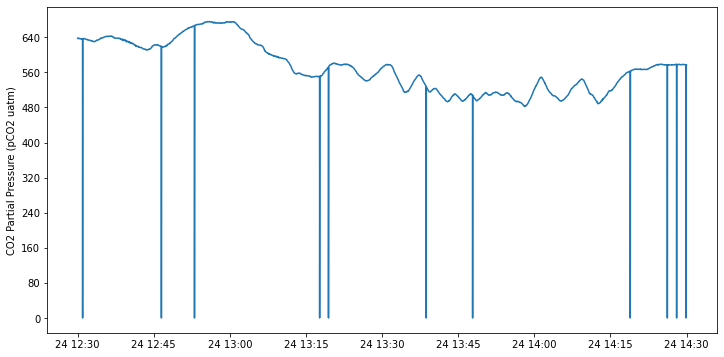

In [4]:
fig, ax = plt.subplots(1,1, figsize = (12,6))
ax.plot(data['datetime'],data['pCO2'])
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylabel('CO2 Partial Pressure (pCO2 uatm)')

#### Write two sentences describing if the outliers are occurring randomly or there is a pattern?
In this time range the pCO2 data goes to zero (an unreasonable number for pCO2) 11 times. This appears to be occuring randomly in both time and values (the outlier does not occur consistently at a peak or a trough, or a rise or fall in teh pCO2 values). <br>
Looking at the data on the ONC webtool for the same time-range, these outliers are not present in any of the other sensors so it is clear that something is going wrong with the pCO2 measurement.  

# Question 3

In [5]:
d = np.array(data['pCO2']).reshape(-1, 1)
clf = LOF(n_neighbors=10)
clf.fit_predict(d)
lof10 = abs(clf.negative_outlier_factor_)

clf = LOF(n_neighbors=100)
clf.fit_predict(d)
lof100 = abs(clf.negative_outlier_factor_)

clf = LOF(n_neighbors=1000)
clf.fit_predict(d)
lof1000 = abs(clf.negative_outlier_factor_)

clf = LOF(n_neighbors=2000)
clf.fit_predict(d)
lof2000 = abs(clf.negative_outlier_factor_)

In [6]:
# make array of the data removed for plotting
rem10 = d[lof10 > 2]
time10 = data['datetime'][lof10 > 2]
rem100 = d[lof100 > 2]
time100 = data['datetime'][lof100 > 2]
rem1000 = d[lof1000 > 2]
time1000 = data['datetime'][lof1000 > 2]
rem2000 = d[lof2000 > 2]
time2000 = data['datetime'][lof2000 > 2]

In [8]:
print(len(rem10))
print(len(rem100))

85
71


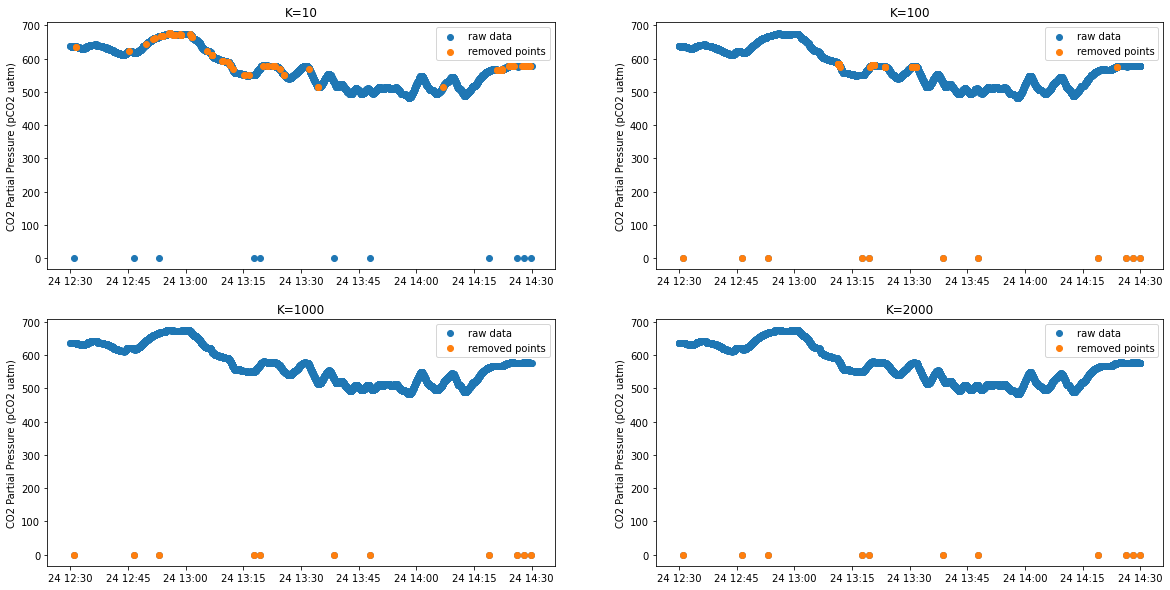

In [9]:
fig, ax = plt.subplots(2,2,figsize=(20,10))

ax[0,0].scatter(data['datetime'], data['pCO2'], label='raw data')
ax[0,0].scatter(time10, rem10, label='removed points')
ax[0,0].set_title('K=10')
ax[0,0].set_ylabel('CO2 Partial Pressure (pCO2 uatm)')
ax[0,0].legend()

ax[0,1].scatter(data['datetime'], data['pCO2'], label='raw data')
ax[0,1].scatter(time100, rem100, label='removed points')
ax[0,1].set_title('K=100')
ax[0,1].set_ylabel('CO2 Partial Pressure (pCO2 uatm)')
ax[0,1].legend()

ax[1,0].scatter(data['datetime'], data['pCO2'], label='raw data')
ax[1,0].scatter(time1000, rem1000, label='removed points')
ax[1,0].set_title('K=1000')
ax[1,0].set_ylabel('CO2 Partial Pressure (pCO2 uatm)')
ax[1,0].legend()

ax[1,1].scatter(data['datetime'], data['pCO2'], label='raw data')
ax[1,1].scatter(time2000, rem2000, label='removed points')
ax[1,1].set_title('K=2000')
ax[1,1].set_ylabel('CO2 Partial Pressure (pCO2 uatm)')
ax[1,1].legend()

#### Comment on your plots and describe the differences between using higher or lower numbers for K.
In the K=10 plot none of the clear outliers are removed while points are removed from what looks to be part of the resonable trend in data. In the K=100 plot this is improved, all the clear outliers are removed and fewer (but not none) of the 'on trend' data points are removed. The plots for both K=1000 and K=2000 look identical, with only the clear outliers removed.  <br>

Using higher numbers for K is more effective at picking out the outliers than ower numbers for K. Additionally, small numbers for K may highlight points that have a fast change between points as outliers, when they otherwise look reasonable, due to the small group of neighbours it is looking at at a time. <br>

NOTE: of a threshold of 2 was used

# Question 4

In [10]:
(len(d))/8

828.875

In [11]:
# lets do 8 chunks of size 829 (with the last being 827)
chunk1 = d[0:829]
chunk2 = d[829:829*2]
chunk3 = d[829*2:829*3]
chunk4 = d[829*3:829*4]
chunk5 = d[829*4:829*5]
chunk6 = d[829*5:829*6]
chunk7 = d[829*6:829*7]
chunk8 = d[829*7:]
chunks = [chunk1, chunk2, chunk3, chunk4, chunk5, chunk6, chunk7, chunk8]

In [12]:
# for K=10
lof10 = []
for c in chunks:
    clf = LOF(n_neighbors=10)
    clf.fit_predict(c)
    lof = abs(clf.negative_outlier_factor_)
    
    lof10 = np.append(lof10,lof)
    
rem10 = d[lof10 > 2]
time10 = data['datetime'][lof10 > 2]

In [13]:
# for K=100
lof100 = []
for c in chunks:
    clf = LOF(n_neighbors=100)
    clf.fit_predict(c)
    lof = abs(clf.negative_outlier_factor_)
    
    lof100 = np.append(lof100,lof)
    
rem100 = d[lof100 > 2]
time100 = data['datetime'][lof100 > 2]

In [14]:
# for K=500
lof500 = []
for c in chunks:
    clf = LOF(n_neighbors=500)
    clf.fit_predict(c)
    lof = abs(clf.negative_outlier_factor_)
    
    lof500 = np.append(lof500,lof)
    
rem500 = d[lof500 > 2]
time500 = data['datetime'][lof500 > 2]

In [15]:
# for K=800
lof800 = []
for c in chunks:
    clf = LOF(n_neighbors=800)
    clf.fit_predict(c)
    lof = abs(clf.negative_outlier_factor_)
    
    lof800 = np.append(lof800,lof)
    
rem800 = d[lof800 > 2]
time800 = data['datetime'][lof800 > 2]

In [22]:
print(len(rem10))
print(len(rem100))
print(len(rem1000))
print(len(rem2000))
print(len(rem800))

168
216
11
11
11


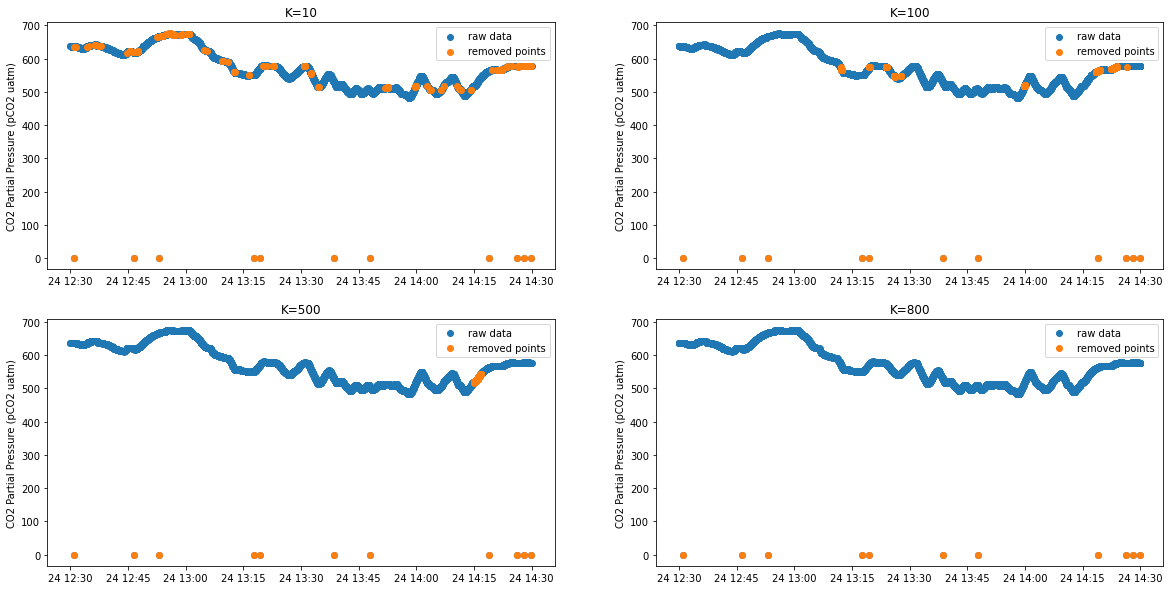

In [18]:
fig, ax = plt.subplots(2,2,figsize=(20,10))

ax[0,0].scatter(data['datetime'], data['pCO2'], label='raw data')
ax[0,0].scatter(time10, rem10, label='removed points')
ax[0,0].set_title('K=10')
ax[0,0].set_ylabel('CO2 Partial Pressure (pCO2 uatm)')
ax[0,0].legend()

ax[0,1].scatter(data['datetime'], data['pCO2'], label='raw data')
ax[0,1].scatter(time100, rem100, label='removed points')
ax[0,1].set_title('K=100')
ax[0,1].set_ylabel('CO2 Partial Pressure (pCO2 uatm)')
ax[0,1].legend()

ax[1,0].scatter(data['datetime'], data['pCO2'], label='raw data')
ax[1,0].scatter(time500, rem500, label='removed points')
ax[1,0].set_title('K=500')
ax[1,0].set_ylabel('CO2 Partial Pressure (pCO2 uatm)')
ax[1,0].legend()

ax[1,1].scatter(data['datetime'], data['pCO2'], label='raw data')
ax[1,1].scatter(time800, rem800, label='removed points')
ax[1,1].set_title('K=800')
ax[1,1].set_ylabel('CO2 Partial Pressure (pCO2 uatm)')
ax[1,1].legend()

#### What are the main differences compared to your previous plots at step 3?
The main differences are 1) that more 'reasonable' data points are highlighted as outliers (for example, K=100 goes from having 59 non-outlier points highlighted to 205) and 2) the 11 true outliers were found even with small values of K (K=10). <br>

NOTE: a threshold of 2 was used again

# Question 5

#### Based on your experience so far, what are the advantages and disadvantages of using LOF? 
The advantages of using LOF are that it is a very computationally efficient method of identifying outliers, it is easilly customizable to a specific data set, and once customized can effectively identify outliers. <br>
The disadvantages of using LOF is that is it very sensitive to the K value chosen and to the outlier factor chosen as the cuttoff between reasonable values and outliers. Incorrect choices for these may lead to the process missing outliers and/or flagging values that are not outliers. As such, the user must test these choices with a sample dataset that they understand quite well before letting the LOF method go unsupervised on the data. Another disadvantage is that a large dataset is required to make the method work properly as seen when comparing the results between questions 3 and 4. 

#### Is it working well with larger or smaller data points or it doesn’t matter? Why do you think so?
I think that the LOF method works better with larger datasets because a larger number of neighbours can be looked at in order to identify the outliers. For example, if you have an infinite number of observations then it is easy to idenfity what doesn't fit because you have an infinite number of points to compare to; however, if you only have 2 points it is impossible to determine which, if either, are the outlier without knowing something already about your data. This was confinrmend in this assignment by the fact that the larger K values were consistently better at identifying the outliers, and K can only be as large as the dataset itself. 